In [ ]:
"""
Program klasyfikuje jakość białego wina przy użyciu drzew decyzyjnych i SVM, wykonując analizę danych, strojenie modeli oraz porównanie ich skuteczności.

autorzy:
s27433
s28866
"""


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import clone
from itertools import product

In [2]:
wine_data = pd.read_csv('winequality-white.csv', sep=';')


In [3]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# EDA

In [4]:
def dataset_summary(data):
    """Zwraca tabelę podsumowującą typy danych, braki, wartości zerowe oraz podstawowe statystyki opisowe dla każdej kolumny."""
    dataset_summary = pd.DataFrame({    
        "num_unique": data.nunique(),
        "num_missing": data.isnull().sum(),
        "num_missing": data.isnull().sum(),
        "num_missing": data.isnull().sum(),
        "num_inf": np.isinf(data.select_dtypes(include=[np.number])).sum(),
        "dtype": data.dtypes,
        "num_zeros": (data.select_dtypes(include=[np.number]) == 0).sum(),
        "mean": data.mean(numeric_only=True),
        "std": data.std(numeric_only=True),
        "min": data.min(numeric_only=True),
        "max": data.max(numeric_only=True)
        })
    return dataset_summary

In [5]:
dataset_summary(wine_data)

,num_unique,num_missing,num_inf,dtype,num_zeros,mean,std,min,max
fixed acidity,68,0,0,float64,0,6.854788,0.843868,3.80000,14.20000
volatile acidity,125,0,0,float64,0,0.278241,0.100795,0.08000,1.10000
citric acid,87,0,0,float64,19,0.334192,0.121020,0.00000,1.66000
residual sugar,310,0,0,float64,0,6.391415,5.072058,0.60000,65.80000
chlorides,160,0,0,float64,0,0.045772,0.021848,0.00900,0.34600
free sulfur dioxide,132,0,0,float64,0,35.308085,17.007137,2.00000,289.00000
total sulfur dioxide,251,0,0,float64,0,138.360657,42.498065,9.00000,440.00000
density,890,0,0,float64,0,0.994027,0.002991,0.98711,1.03898
pH,103,0,0,float64,0,3.188267,0.151001,2.72000,3.82000
sulphates,79,0,0,float64,0,0.489847,0.114126,0.22000,1.08000


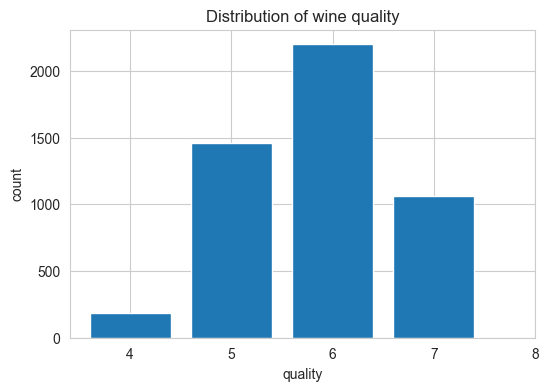

In [15]:
import matplotlib.pyplot as plt

y = wine_data["quality"]

plt.figure(figsize=(6, 4))
plt.hist(y, bins=sorted(y.unique()), align="left", rwidth=0.8)
plt.xlabel("quality")
plt.ylabel("count")
plt.title("Distribution of wine quality")
plt.xticks(sorted(y.unique()))
plt.show()


In [7]:
# Spłaszcza skrajne wartości jakości do zakresu od 4 do 8.
wine_data[wine_data['quality'] <= 4] = 4
wine_data[wine_data['quality'] >=8] = 8

In [ ]:
import matplotlib.pyplot as plt

y = wine_data["quality"]

plt.figure(figsize=(12, 8))
plt.hist(y, bins=sorted(y.unique()), align="left",)
plt.xlabel("quality")
plt.ylabel("count")
plt.title("Distribution of wine quality")
plt.xticks(sorted(y.unique()))
plt.show()


In [9]:
y.unique()

array([6, 5, 7, 8, 4], dtype=int64)

In [14]:
wine_data[wine_data["quality"] == 4] 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
46,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
98,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
115,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
147,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
172,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
4774,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
4779,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
4804,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4
4839,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4


# Fatures Enginnering

# modeling

In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = wine_data.drop("quality", axis=1)
y = wine_data["quality"]
# Dzieli dane na zbiory treningowy i testowy.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

svm_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", SVC())
    ]
)

svm_param_grid = {
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"]
}
# Przeprowadza wyszukiwanie najlepszej konfiguracji SVM przy użyciu walidacji krzyżowej.
svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
)
# Oblicza predykcje SVM na zbiorze testowym i wypisuje podstawowe miary jakości klasyfikacji.
svm_grid.fit(X_train, y_train)

y_pred_svm = svm_grid.predict(X_test)
# Oblicza predykcje SVM na zbiorze testowym i wypisuje podstawowe miary jakości klasyfikacji.
print("SVM best params:", svm_grid.best_params_)
print("SVM best CV accuracy:", svm_grid.best_score_)
print("SVM test accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM classification report:\n", classification_report(y_test, y_pred_svm))
print("SVM confusion matrix:\n", confusion_matrix(y_test, y_pred_svm))

svm_cv_results = (
    pd.DataFrame(svm_grid.cv_results_)
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)
print("Top 10 SVM CV results:")
print(svm_cv_results[["mean_test_score", "std_test_score", "mean_train_score", "param_clf__kernel", "param_clf__class_weight"]].head(10))
# Inicjalizuje klasyfikator drzewa decyzyjnego z ustaloną losowością dla powtarzalności wyników.
tree_clf = DecisionTreeClassifier(random_state=42)

tree_param_grid = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

tree_grid = GridSearchCV(
    estimator=tree_clf,
    param_grid=tree_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

tree_grid.fit(X_train, y_train)
y_pred_tree = tree_grid.predict(X_test)

print("\nDecision Tree best params:", tree_grid.best_params_)
print("Decision Tree best CV accuracy:", tree_grid.best_score_)
print("Decision Tree test accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree classification report:\n", classification_report(y_test, y_pred_tree))
print("Decision Tree confusion matrix:\n", confusion_matrix(y_test, y_pred_tree))

tree_cv_results = (
    pd.DataFrame(tree_grid.cv_results_)
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 Decision Tree CV results:")
print(tree_cv_results[["mean_test_score", "std_test_score", "mean_train_score", "param_max_depth", "param_min_samples_split", "param_min_samples_leaf", "param_criterion"]].head(10))
# Zestawia w jednej tabeli najlepsze wyniki walidacji krzyżowej oraz dokładności testowej dla SVM i drzewa decyzyjnego.
summary = pd.DataFrame(
    {
        "model": ["SVM", "Decision Tree"],
        "best_cv_accuracy": [svm_grid.best_score_, tree_grid.best_score_],
        "test_accuracy": [
            accuracy_score(y_test, y_pred_svm),
            accuracy_score(y_test, y_pred_tree),
        ],
    }
)
print("\nModel comparison:")
print(summary)


SVM best params: {'clf__class_weight': None, 'clf__kernel': 'rbf'}
SVM best CV accuracy: 0.5977591419709646
SVM test accuracy: 0.6244897959183674
SVM classification report:
               precision    recall  f1-score   support

           4       1.00      1.00      1.00        37
           5       0.62      0.58      0.60       291
           6       0.58      0.78      0.66       440
           7       0.68      0.16      0.26       176
           8       1.00      1.00      1.00        36

    accuracy                           0.62       980
   macro avg       0.78      0.70      0.70       980
weighted avg       0.64      0.62      0.60       980

SVM confusion matrix:
 [[ 37   0   0   0   0]
 [  0 170 121   0   0]
 [  0  86 341  13   0]
 [  0  20 128  28   0]
 [  0   0   0   0  36]]
Top 10 SVM CV results:
   mean_test_score  std_test_score  mean_train_score param_clf__kernel  \
0         0.597759        0.011749          0.612877               rbf   
1         0.595716        0

SVM best params: {'clf__class_weight': None, 'clf__kernel': 'rbf'}
SVM best CV accuracy: 0.5977591419709646
SVM test accuracy: 0.6244897959183674
SVM classification report:
               precision    recall  f1-score   support

           4       1.00      1.00      1.00        37
           5       0.62      0.58      0.60       291
           6       0.58      0.78      0.66       440
           7       0.68      0.16      0.26       176
           8       1.00      1.00      1.00        36

    accuracy                           0.62       980
   macro avg       0.78      0.70      0.70       980
weighted avg       0.64      0.62      0.60       980

SVM confusion matrix:
 [[ 37   0   0   0   0]
 [  0 170 121   0   0]
 [  0  86 341  13   0]
 [  0  20 128  28   0]
 [  0   0   0   0  36]]
Top 10 SVM CV results:
   mean_test_score  std_test_score  mean_train_score param_clf__kernel  \
0         0.597759        0.011749          0.612877               rbf   
1         0.595716        0

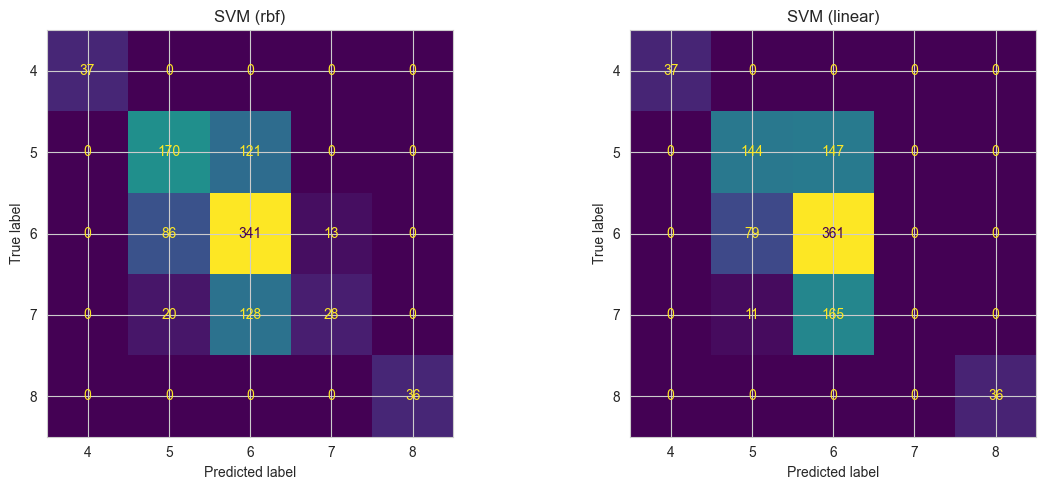

<Figure size 600x500 with 0 Axes>

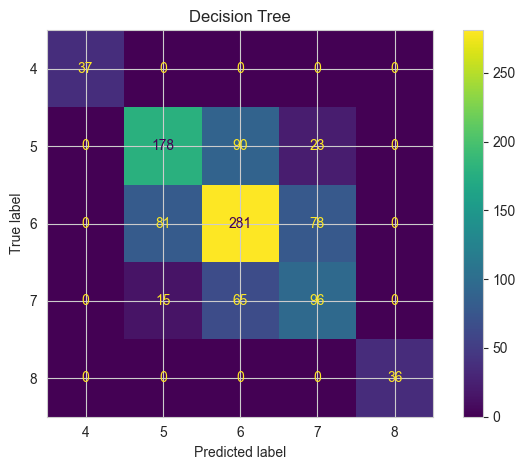


Random sample true labels:
[5 5 7 8 6]
SVM rbf predictions:
[5 5 6 8 6]
SVM linear predictions:
[5 5 6 8 6]
Decision Tree predictions:
[5 5 7 8 6]


In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.base import clone
import matplotlib.pyplot as plt
import joblib

X = wine_data.drop("quality", axis=1)
y = wine_data["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

svm_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", SVC())
    ]
)

svm_param_grid = {
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"]
}

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
)

svm_grid.fit(X_train, y_train)

y_pred_svm = svm_grid.predict(X_test)

print("SVM best params:", svm_grid.best_params_)
print("SVM best CV accuracy:", svm_grid.best_score_)
print("SVM test accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM classification report:\n", classification_report(y_test, y_pred_svm))
print("SVM confusion matrix:\n", confusion_matrix(y_test, y_pred_svm))

svm_cv_results = (
    pd.DataFrame(svm_grid.cv_results_)
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)
print("Top 10 SVM CV results:")
print(svm_cv_results[["mean_test_score", "std_test_score", "mean_train_score", "param_clf__kernel", "param_clf__class_weight"]].head(10))

tree_clf = DecisionTreeClassifier(random_state=42)

tree_param_grid = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

tree_grid = GridSearchCV(
    estimator=tree_clf,
    param_grid=tree_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

tree_grid.fit(X_train, y_train)
y_pred_tree = tree_grid.predict(X_test)

print("\nDecision Tree best params:", tree_grid.best_params_)
print("Decision Tree best CV accuracy:", tree_grid.best_score_)
print("Decision Tree test accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree classification report:\n", classification_report(y_test, y_pred_tree))
print("Decision Tree confusion matrix:\n", confusion_matrix(y_test, y_pred_tree))

tree_cv_results = (
    pd.DataFrame(tree_grid.cv_results_)
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 Decision Tree CV results:")
print(tree_cv_results[["mean_test_score", "std_test_score", "mean_train_score", "param_max_depth", "param_min_samples_split", "param_min_samples_leaf", "param_criterion"]].head(10))

summary = pd.DataFrame(
    {
        "model": ["SVM", "Decision Tree"],
        "best_cv_accuracy": [svm_grid.best_score_, tree_grid.best_score_],
        "test_accuracy": [
            accuracy_score(y_test, y_pred_svm),
            accuracy_score(y_test, y_pred_tree),
        ],
    }
)
print("\nModel comparison:")
print(summary)





classes = np.sort(y.unique())

svm_results_df = pd.DataFrame(svm_grid.cv_results_)

best_svm_models = {}
for kernel in ["rbf", "linear"]:
    kernel_rows = svm_results_df[svm_results_df["param_clf__kernel"] == kernel]
    best_idx = kernel_rows["mean_test_score"].idxmax()
    best_params_kernel = {
        "clf__kernel": svm_results_df.loc[best_idx, "param_clf__kernel"],
        "clf__class_weight": svm_results_df.loc[best_idx, "param_clf__class_weight"],
    }
    model = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("clf", SVC())
        ]
    )
    model.set_params(**best_params_kernel)
    model.fit(X_train, y_train)
    best_svm_models[kernel] = model

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (kernel, model) in zip(axes, best_svm_models.items()):
    y_pred_kernel = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_kernel, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"SVM ({kernel})")
plt.tight_layout()
plt.show()

best_tree_model = tree_grid.best_estimator_
y_pred_tree_best = best_tree_model.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree_best, labels=classes)
plt.figure(figsize=(6, 5))
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=classes)
disp_tree.plot()
plt.title("Decision Tree")
plt.tight_layout()
plt.show()



In [19]:
joblib.dump(best_svm_models["rbf"], "best_svm_rbf.joblib")
joblib.dump(best_svm_models["linear"], "best_svm_linear.joblib")
joblib.dump(best_tree_model, "best_decision_tree.joblib")

loaded_svm_rbf = joblib.load("best_svm_rbf.joblib")
loaded_svm_linear = joblib.load("best_svm_linear.joblib")
loaded_tree = joblib.load("best_decision_tree.joblib")

random_sample = X_test.sample(n=5, random_state=0)
random_true = y_test.loc[random_sample.index]

print("\nRandom sample true labels:")
print(random_true.values)
print("SVM rbf predictions:")
print(loaded_svm_rbf.predict(random_sample))
print("SVM linear predictions:")
print(loaded_svm_linear.predict(random_sample))
print("Decision Tree predictions:")
print(loaded_tree.predict(random_sample))



Random sample true labels:
[5 5 7 8 6]
SVM rbf predictions:
[5 5 6 8 6]
SVM linear predictions:
[5 5 6 8 6]
Decision Tree predictions:
[5 5 7 8 6]
